# EN3150 Assignment 03: Simple convolutional neural network to perform classification.

Done by:

- Alahakoon U.M.Y.B. (210027C)
- Dulnath
- Jayakumar W.S. (210236P)
- Ratnayake

Instructed by: Dr. Sampath K. Perera

In this assignemnt, our focus is to create a simple image classifier using convolutional neural networks (CNN).

### Import necessary packages

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
print(device)

cuda


In [3]:
full_dataset = ImageFolder(root='Realwaste', transform=transforms.Compose([
    transforms.Resize((131, 131)),
    transforms.ToTensor()
]))
print(full_dataset.classes)
print(len(full_dataset))

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
4752


In [4]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.6), 
                                                                                          int(len(full_dataset) * 0.2), 
                                                                                          len(full_dataset) - int(len(full_dataset) * 0.6) - int(len(full_dataset) * 0.2)])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

test_targets = [test_dataset.dataset.targets[i] for i in test_dataset.indices]

2851
950
951


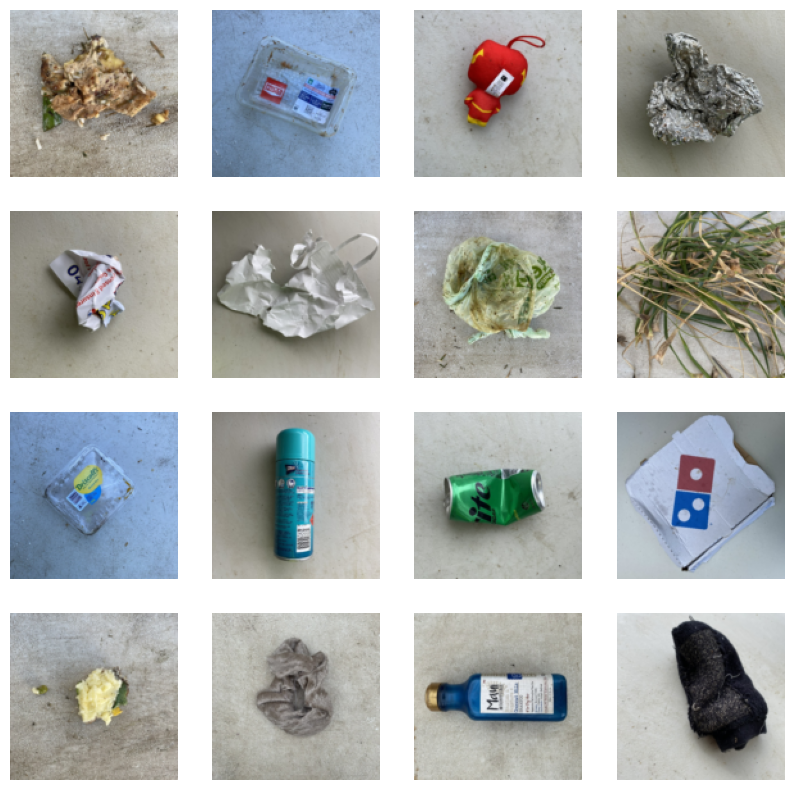

In [5]:
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
plt.show()

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 9)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [8]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device,
          to_print: bool) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        if to_print:
            print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [9]:
def calculate_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            x, y = inputs.to(device), labels.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total, torch.cat(predictions)

In [10]:
model = cnn_model().to(device)
print(summary(cnn_model(), input_size=(BATCH_SIZE, 3, 131, 131)))

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 9]                   --
├─Sequential: 1-1                        [32, 16, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 16, 129, 129]        448
│    └─ReLU: 2-2                         [32, 16, 129, 129]        --
│    └─MaxPool2d: 2-3                    [32, 16, 64, 64]          --
├─Sequential: 1-2                        [32, 32, 31, 31]          --
│    └─Conv2d: 2-4                       [32, 32, 62, 62]          4,640
│    └─ReLU: 2-5                         [32, 32, 62, 62]          --
│    └─MaxPool2d: 2-6                    [32, 32, 31, 31]          --
├─Sequential: 1-3                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-7                       [32, 64, 29, 29]          18,496
│    └─ReLU: 2-8                         [32, 64, 29, 29]          --
│    └─MaxPool2d: 2-9                    [32, 64, 14, 14]          --
├─Flatt

In [11]:
iterations = 20
loss = nn.CrossEntropyLoss()
model = cnn_model().to(device) # This is used to reset the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 2.162530371877882, Test Loss: 2.101095167795817, Train Accuracy: 0.18098912662223782, Test Accuracy: 0.2031578947368421
Epoch 2 / 20, Train Loss: 2.102142181661394, Test Loss: 2.0140013376871746, Train Accuracy: 0.2304454577341284, Test Accuracy: 0.24421052631578946
Epoch 3 / 20, Train Loss: 2.018643301063114, Test Loss: 1.8748780965805054, Train Accuracy: 0.25429673798667135, Test Accuracy: 0.3021052631578947
Epoch 4 / 20, Train Loss: 1.92974927160475, Test Loss: 1.7783446431159973, Train Accuracy: 0.284461592423711, Test Accuracy: 0.3526315789473684
Epoch 5 / 20, Train Loss: 1.8162226782904731, Test Loss: 1.7980563084284464, Train Accuracy: 0.3293581199579095, Test Accuracy: 0.3547368421052632
Epoch 6 / 20, Train Loss: 1.7602897432115343, Test Loss: 1.6379841605822245, Train Accuracy: 0.37144861452122063, Test Accuracy: 0.42736842105263156
Epoch 7 / 20, Train Loss: 1.683394686381022, Test Loss: 1.530283558368683, Train Accuracy: 0.3861802876183795, Test Accu

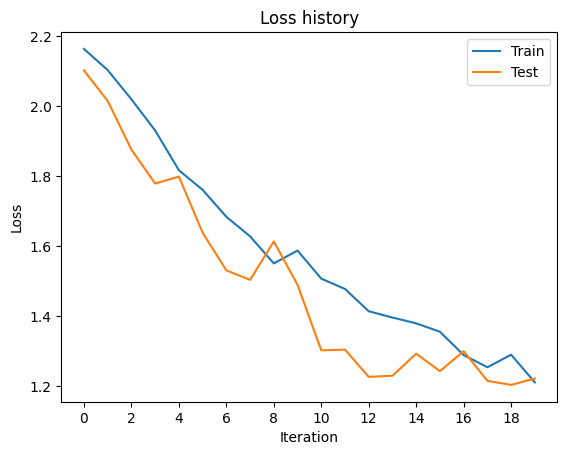

In [12]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

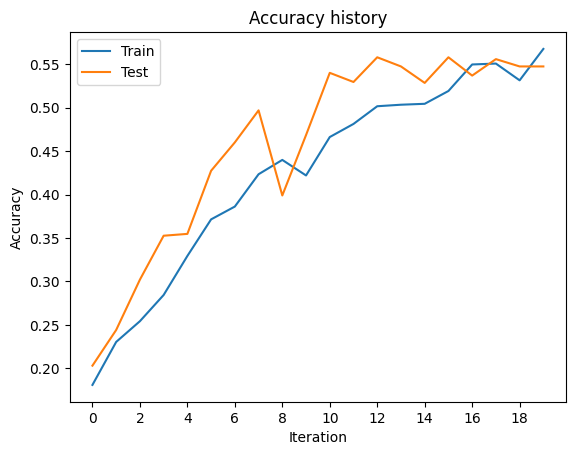

In [13]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 54.7844374342797%


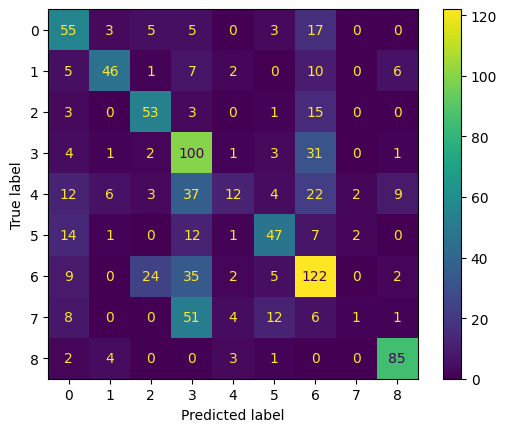

In [14]:
test_accuracy, test_predictions = calculate_accuracy(model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [15]:
train_accuracy,_ = calculate_accuracy(model, train_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 63.98%
Test accuracy: 54.78%


In [16]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
iterations = 20
train_accuracy_history_lr = [ ]
test_accuracy_history_lr = [ ]
loss = nn.CrossEntropyLoss()
for learning_rate in learning_rates:
    model = cnn_model().to(device) # This is used to reset the model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, train_dataloader, test_dataloader, iterations, optimizer, loss, device, False)
    train_accuracy_history_lr.append(train_accuracy_hist[-1])
    test_accuracy_history_lr.append(test_accuracy_hist[-1])
    print(f"Learning Rate: {learning_rate}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

Learning Rate: 0.0001, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.001, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.01, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.1, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797


### Using a SOTA model

In this section, we will use a ResNet-18 model to perform the classification task. We will use the pre-trained model and fine-tune it to our dataset.

In [53]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # These are the default weights
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 524, 524), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 524, 524]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 524, 524]         [32, 64, 262, 262]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 262, 262]        [32, 64, 262, 262]        128                       True
├─ReLU: 1-3                              [32, 64, 262, 262]        [32, 64, 262, 262]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 262, 262]        [32, 64, 131, 131]        --                        --
├─Sequential: 1-5                        [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    └─BasicBlock: 2-1                   [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    │ 

In [54]:
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(in_features=512, out_features=9, bias=True).to(device)
print(resnet_model.fc)

Linear(in_features=512, out_features=9, bias=True)


In [55]:
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 524, 524), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 524, 524]         [32, 9]                   --                        Partial
├─Conv2d: 1-1                            [32, 3, 524, 524]         [32, 64, 262, 262]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 262, 262]        [32, 64, 262, 262]        (128)                     False
├─ReLU: 1-3                              [32, 64, 262, 262]        [32, 64, 262, 262]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 262, 262]        [32, 64, 131, 131]        --                        --
├─Sequential: 1-5                        [32, 64, 131, 131]        [32, 64, 131, 131]        --                        False
│    └─BasicBlock: 2-1                   [32, 64, 131, 131]        [32, 64, 131, 131]        --                        False


In [56]:
full_dataset = ImageFolder(root='Realwaste', transform=transforms.Compose([
    transforms.ToTensor()
]))

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.6), 
                                                                                          int(len(full_dataset) * 0.2), 
                                                                                          len(full_dataset) - int(len(full_dataset) * 0.6) - int(len(full_dataset) * 0.2)])

test_targets = [test_dataset.dataset.targets[i] for i in test_dataset.indices]

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [ ]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.744668624136183, Test Loss: 1.3667133092880248, Train Accuracy: 0.41809891266222377, Test Accuracy: 0.6189473684210526
Epoch 2 / 20, Train Loss: 1.261821186542511, Test Loss: 1.0721993684768676, Train Accuracy: 0.615924237109786, Test Accuracy: 0.6894736842105263
Epoch 3 / 20, Train Loss: 1.0358886553181543, Test Loss: 0.9550912102063497, Train Accuracy: 0.6801122413188355, Test Accuracy: 0.6989473684210527
Epoch 4 / 20, Train Loss: 0.9506065269311269, Test Loss: 0.8699563165505727, Train Accuracy: 0.7102770957558752, Test Accuracy: 0.7115789473684211
Epoch 5 / 20, Train Loss: 0.8881971147325304, Test Loss: 0.8058669050534566, Train Accuracy: 0.7232549982462294, Test Accuracy: 0.7452631578947368
Epoch 6 / 20, Train Loss: 0.8273936265044742, Test Loss: 0.7649739881356558, Train Accuracy: 0.7246580147316731, Test Accuracy: 0.7463157894736843
Epoch 7 / 20, Train Loss: 0.7827486554781596, Test Loss: 0.7118890434503555, Train Accuracy: 0.7520168361978253, Test Ac

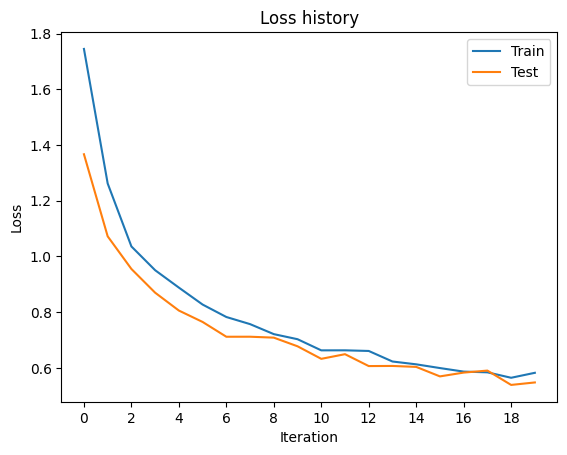

In [59]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

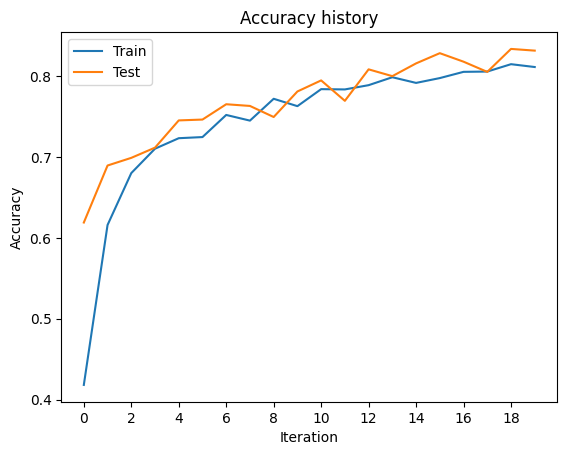

In [60]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 79.49526813880126%


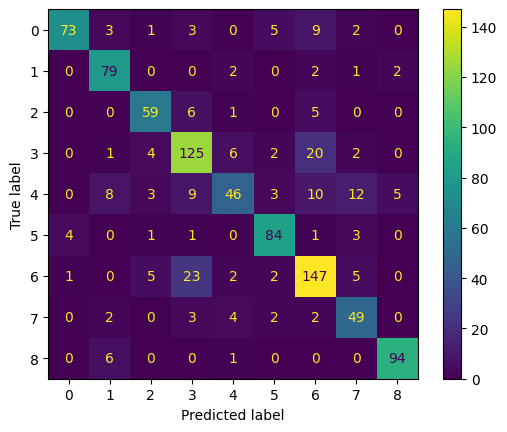

In [62]:
test_accuracy, test_predictions = calculate_accuracy(resnet_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [64]:
train_accuracy,_ = calculate_accuracy(resnet_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(resnet_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 84.18%
Test accuracy: 79.50%
